In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf
import os


In [2]:
# Image size and batch size
image_size = (380, 380)
batch_size = 64

### Load the folder and label

In [3]:
# The main folder
# base_path = "/Users/mrbinit/Downloads/preprocessed/"
base_path = "/content/drive/My Drive/preprocessed"

# Create list of file paths and corresponding labels
file_paths = []
labels = []

# Iterate through 'fake' and 'real' subfolders to collect file paths and labels
for label, category in enumerate(['fake', 'real']):
    category_path = os.path.join(base_path, category)
    for file_name in os.listdir(category_path):
        file_path = os.path.join(category_path, file_name)
        file_paths.append(file_path)
        labels.append(label)  # Assign label 0 for 'fake' and 1 for 'real'

In [4]:
import cv2
# Check the dimension of the data
def get_image_dimensions(file_path):
    img = cv2.imread(file_path)

    if img is not None:
        # Get image dimensions (height, width, channels)
        height, width, channels = img.shape
        return height, width, channels
    else:
        print(f"Error: Failed to load image at {file_path}")
        return None

# Display dimensions of the first 5 images
num_images_to_display = 5

if len(file_paths) >= num_images_to_display:
    print(f"Displaying dimensions of the first {num_images_to_display} images:")

    for i in range(num_images_to_display):
        image_path = file_paths[i]
        dimensions = get_image_dimensions(image_path)

        if dimensions is not None:
            height, width, channels = dimensions
            print(f"Image {i+1}:")
            print(f"  Height: {height} pixels")
            print(f"  Width: {width} pixels")
            print(f"  Channels (depth): {channels}")
        else:
            print(f"Image {i+1}: Error loading image dimensions")
else:
    print("No image files found")

Displaying dimensions of the first 5 images:
Image 1:
  Height: 1024 pixels
  Width: 1024 pixels
  Channels (depth): 3
Image 2:
  Height: 1024 pixels
  Width: 1536 pixels
  Channels (depth): 3
Image 3:
  Height: 1024 pixels
  Width: 1024 pixels
  Channels (depth): 3
Image 4:
  Height: 1024 pixels
  Width: 1024 pixels
  Channels (depth): 3
Image 5:
  Height: 512 pixels
  Width: 1024 pixels
  Channels (depth): 3


### Visualization with labels

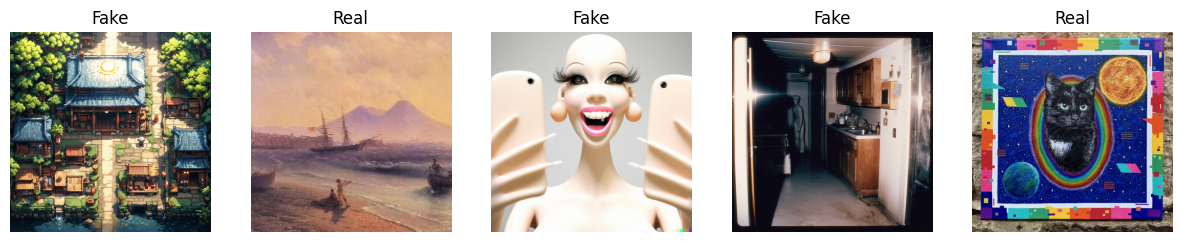

In [5]:
import matplotlib.pyplot as plt
import random

num_images_to_display = 5

if len(file_paths) >= num_images_to_display:
    plt.figure(figsize=(15, 8))
    random_indices = random.sample(range(len(file_paths)), num_images_to_display)

    for i, idx in enumerate(random_indices):
        image_path = file_paths[idx]
        label = labels[idx]
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib

        # Display image with label
        plt.subplot(1, num_images_to_display, i + 1)
        plt.imshow(img)

        if label == 0:
            plt.title("Fake")
        elif label == 1:
            plt.title("Real")

        plt.axis('off')

    plt.show()
else:
    print("No image files found")

### Data augmentation

In [6]:
img_augmentation_layers = [
    tf.keras.layers.RandomRotation(factor = 0.15),
    tf.keras.layers.RandomTranslation(height_factor = 0.1, width_factor = 0.1),
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomContrast(factor = 0.1),
]

### Data preprocessing

In [7]:
from tensorflow.keras.applications.efficientnet import preprocess_input
# Function to preprocess the data
def preprocess_image(file_path, label, augment = False):
    # Load and decode image
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Ensure 3 channels (RGB)
    # Apply image augmentation
    if augment:
        # Apply data augmentation to training images
        for layer in img_augmentation_layers:
            img = layer(img)
    # Resize image (*380 for efficientNetb44)
    img = tf.image.resize(img, image_size)

    # Preprocess image using EfficientNet preprocessing
    img = preprocess_input(img)

    return img, label

the key steps in preprocess input efficientNetb4 :
1. Normalization (centered around zero (mean subtraction) and scales them by dividing by the standard deviation.)
2. Mean subtraction (This helps in centering the pixel values around zero, which is important for training stability and convergence)
3. Channel ordering as EfficientNetB4 inputimages in RGB(Red-Green-Blue) . If the input image is in BGR (Blue-Green-Red) format (common with images loaded using OpenCV), the function performs the necessary conversion to RGB.

4. Scaling (The pixel values are scaled based on the standard deviation computed from the ImageNet dataset.). This step ensures that the input image data falls within a reasonable range that is suitable for the EfficientNetB4 model.


### Data split (train, test and validation)

In [8]:
from sklearn.model_selection import train_test_split

# Split data into training, validation, and test sets with stratified sampling
train_file_paths, test_file_paths, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.2, stratify=labels, random_state=42)

train_file_paths, val_file_paths, train_labels, val_labels = train_test_split(train_file_paths, train_labels, test_size=0.25, stratify=train_labels, random_state=42)

# Print the length
print("Number of training samples:", len(train_file_paths))
print("Number of training labels:", len(train_labels))
print("Number of validation samples:", len(val_file_paths))
print("Number of validation labels:", len(val_labels))
print("Number of test samples:", len(test_file_paths))
print("Number of test labels:", len(test_labels))


Number of training samples: 4542
Number of training labels: 4542
Number of validation samples: 1515
Number of validation labels: 1515
Number of test samples: 1515
Number of test labels: 1515


In [9]:
# Create TensorFlow datasets for training, validation, and test
train_dataset = tf.data.Dataset.from_tensor_slices((train_file_paths, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_file_paths, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_file_paths, test_labels))

# Map preprocessing function to the datasets
# Only perform data augmentation on Train dataset
train_dataset = train_dataset.map(lambda x, y: preprocess_image(x, y, augment=True), num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(lambda x, y: preprocess_image(x, y, augment=False), num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(lambda x, y: preprocess_image(x, y, augment=False), num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch the training dataset
train_dataset = train_dataset.shuffle(buffer_size=len(train_file_paths)).batch(batch_size)

# Batch the validation dataset. I wont shuffle and perform data augmentation on  test and vad
val_dataset = val_dataset.batch(batch_size)

# Batch the test dataset
test_dataset = test_dataset.batch(batch_size)

Visualizing preprocessed images from the train dataset:


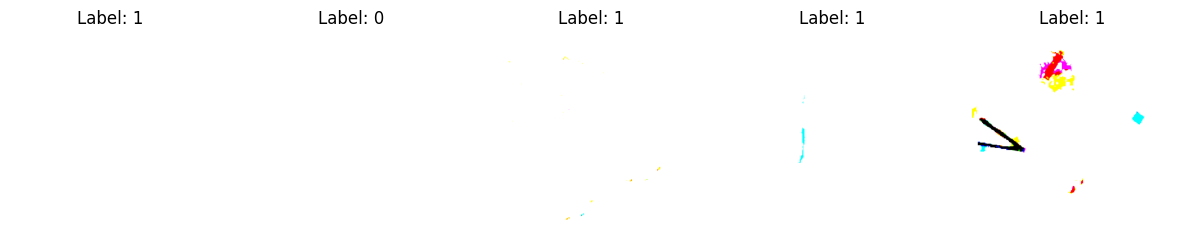

In [15]:
# Function to display preprocessed image
def show_preprocessed_images(dataset, num_images=5):
    plt.figure(figsize=(15, 10))
    for i, (image, label) in enumerate(dataset.take(1)): # only 1 batch
        for j in range(num_images):
            plt.subplot(1, num_images, j + 1)
            plt.imshow(image[j])  # Display j-th image in the batch
            plt.title(f"Label: {label[j].numpy()}")
            plt.axis("off")
    plt.show()
# Visualize preprocessed images from the train dataset
print("Visualizing preprocessed images from the train dataset:")
show_preprocessed_images(train_dataset)


In [ ]:
# import joblib
# joblib.dump(preprocess_image, 'preprocess_image.joblib')

In [10]:
from tensorflow.keras.optimizers import Adam

# Load EfficientNetB4 model pre-trained on ImageNet
base_model = tf.keras.applications.EfficientNetB4(
    weights='imagenet',
    include_top=False,
    input_shape=(image_size[0], image_size[1], 3)
)

# Freeze the base model layers
base_model.trainable = False

# classification head on top of the base model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation='softmax')  # Output layer for binary classification (0, 1)
])

# Compile the model with Adam optimizer and initial learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()


71686520/71686520 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional  (None, 12, 12, 1792)      17673823  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1792)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1793      
                                                                 
Total params: 17675616 (67.43 MB)
Trainable params: 1793 (7.00 KB)
Non-trainable params: 17673823 (67.42 MB)
_________________________________________________________________


In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Unfreeze the last 20 layers of the base model
fine_tune_at = -20

# Unfreeze the selected layers for fine-tuning
for layer in base_model.layers[fine_tune_at:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Specify a lower learning rate for the fine-tuned layers
optimizer = Adam(learning_rate=0.0001)  # Lower learning rate for fine-tuned layers
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Set up a learning rate reduction scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)



In [12]:
# Train the model with fine-tuning
epochs = 10.   #recommended 25 epochs
model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[reduce_lr])

Epoch 1/10
71/71 [==============================] - 867s 8s/step - loss: 0.4810 - accuracy: 0.7871 - val_loss: 0.4156 - val_accuracy: 0.8528
Epoch 2/10
71/71 [==============================] - 814s 8s/step - loss: 0.3290 - accuracy: 0.8844 - val_loss: 0.3626 - val_accuracy: 0.8620
Epoch 3/10
71/71 [==============================] - 810s 8s/step - loss: 0.2908 - accuracy: 0.8939 - val_loss: 0.3427 - val_accuracy: 0.8700
Epoch 4/10
71/71 [==============================] - 807s 8s/step - loss: 0.2646 - accuracy: 0.8998 - val_loss: 0.3394 - val_accuracy: 0.8660
Epoch 5/10
71/71 [==============================] - 803s 8s/step - loss: 0.2559 - accuracy: 0.9018 - val_loss: 0.3269 - val_accuracy: 0.8627
Epoch 6/10
71/71 [==============================] - 812s 8s/step - loss: 0.2497 - accuracy: 0.9053 - val_loss: 0.3220 - val_accuracy: 0.8660
Epoch 7/10
71/71 [==============================] - 803s 8s/step - loss: 0.2376 - accuracy: 0.9102 - val_loss: 0.3177 - val_accuracy: 0.8680
Epoch 8/10
71

In [13]:

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


24/24 [==============================] - 150s 6s/step - loss: 0.3275 - accuracy: 0.8759
Test Loss: 0.3274606466293335
Test Accuracy: 0.8759075999259949


In [14]:

saved_model_path = '/content/drive/My Drive/saved_model'

# Save the model to the specified path
model.save(saved_model_path)